In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import os
import requests


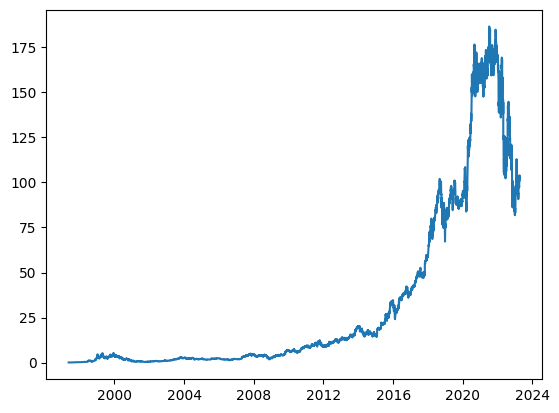

In [143]:
data = pd.read_csv("AMZN.csv")
data = data[['Date','Close']]
data['Date'] = pd.to_datetime(data['Date'])
plt.plot(data['Date'],data['Close'])

# #reset it up using my API
# alphavantage_api_key = os.getenv("ALPHAVANTAGE_API_KEY")
# alphavantage_api_url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=MSFT&outputsize=full&apikey={alphavantage_api_key}"
# response = requests.get(alphavantage_api_url)

# data = response.json()
# data = data['Time Series (Daily)']
# data = pd.DataFrame(data).T
# data = data[['4. close']]
# data = data.reset_index()
# data.columns = ['Date','Close']
# data['Date'] = pd.to_datetime(data['Date'])

In [144]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [145]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df,n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1,n_steps +1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace = True)

    return df


lookback = 7
shift_df = prepare_dataframe_for_lstm(data,lookback)
print(shift_df[:10])
shift_df_as_np = shift_df.to_numpy()
print(shift_df_as_np[:10])

               Close  Close(t-1)  Close(t-2)  Close(t-3)  Close(t-4)  \
Date                                                                   
1997-05-27  0.079167    0.075000    0.069792    0.071354    0.081771   
1997-05-28  0.076563    0.079167    0.075000    0.069792    0.071354   
1997-05-29  0.075260    0.076563    0.079167    0.075000    0.069792   
1997-05-30  0.075000    0.075260    0.076563    0.079167    0.075000   
1997-06-02  0.075521    0.075000    0.075260    0.076563    0.079167   
1997-06-03  0.073958    0.075521    0.075000    0.075260    0.076563   
1997-06-04  0.070833    0.073958    0.075521    0.075000    0.075260   
1997-06-05  0.077083    0.070833    0.073958    0.075521    0.075000   
1997-06-06  0.082813    0.077083    0.070833    0.073958    0.075521   
1997-06-09  0.084375    0.082813    0.077083    0.070833    0.073958   

            Close(t-5)  Close(t-6)  Close(t-7)  
Date                                            
1997-05-27    0.085417    0.086458   

In [146]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
shift_df_as_np = scaler.fit_transform(shift_df_as_np)

shift_df_as_np

array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.09747299,  0.10690997,  0.09308121, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.11398769,  0.09747299,  0.10691495, ...,  0.04203581,
         0.0506149 ,  0.05158   ],
       [ 0.08342464,  0.11398769,  0.09747802, ...,  0.07431453,
         0.04203581,  0.0506149 ]])

In [147]:
X = shift_df_as_np[:, 1:]
Y = shift_df_as_np[:, 0]
X.shape, Y.shape

((6509, 7), (6509,))

In [148]:
X = dc(np.flip(X,axis=1))


In [149]:
split_index = int(len(X) * 0.95)
split_index

X_train = X[:split_index]
X_test = X[split_index:]

Y_train = Y[:split_index]
Y_test = Y[split_index:]

X_train.shape , X_test.shape, Y_train.shape, Y_test.shape

((6183, 7), (326, 7), (6183,), (326,))

In [150]:
X_train = X_train.reshape((-1,lookback,1))
X_test = X_test.reshape((-1,lookback,1))

Y_train = Y_train.reshape((-1,1))
Y_test = Y_test.reshape((-1,1))

X_train.shape , X_test.shape, Y_train.shape, Y_test.shape

((6183, 7, 1), (326, 7, 1), (6183, 1), (326, 1))

In [151]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()

Y_train = torch.tensor(Y_train).float()
Y_test = torch.tensor(Y_test).float()
X_train.shape , X_test.shape, Y_train.shape, Y_test.shape

(torch.Size([6183, 7, 1]),
 torch.Size([326, 7, 1]),
 torch.Size([6183, 1]),
 torch.Size([326, 1]))

In [152]:
from torch.utils.data import DataLoader, TensorDataset

class TimeSeriesDataset(TensorDataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    
train_dataset = TimeSeriesDataset(X_train, Y_train)
test_dataset = TimeSeriesDataset(X_test, Y_test)

In [153]:
batch_szie = 16

train_loader = DataLoader(train_dataset,batch_size=batch_szie,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_szie,shuffle=False)



In [154]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [155]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_szie = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_szie, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch_szie, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
model = LSTM(1,4,1,1).to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [156]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()


In [157]:
epoch = 0

In [158]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [159]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [160]:

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 1.200
Batch 200, Loss: 0.442
Batch 300, Loss: 0.199

Val Loss: 0.335
***************************************************

Epoch: 2
Batch 100, Loss: 0.055
Batch 200, Loss: 0.021
Batch 300, Loss: 0.016

Val Loss: 0.041
***************************************************

Epoch: 3
Batch 100, Loss: 0.012
Batch 200, Loss: 0.010
Batch 300, Loss: 0.010

Val Loss: 0.022
***************************************************

Epoch: 4
Batch 100, Loss: 0.006
Batch 200, Loss: 0.005
Batch 300, Loss: 0.005

Val Loss: 0.016
***************************************************

Epoch: 5
Batch 100, Loss: 0.003
Batch 200, Loss: 0.003
Batch 300, Loss: 0.002

Val Loss: 0.012
***************************************************

Epoch: 6
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.012
***************************************************

Epoch: 7
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.009
*****************

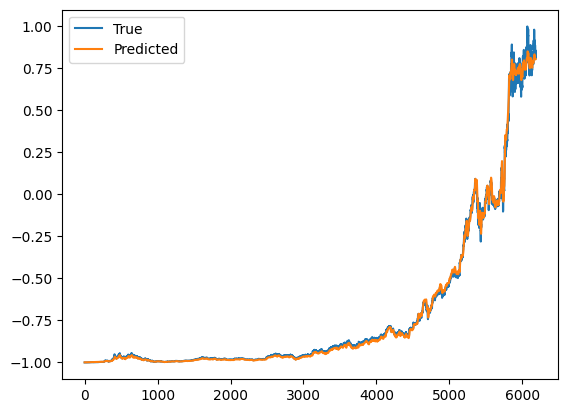

In [161]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(Y_train, label='True')
plt.plot(predicted, label='Predicted')
plt.legend()
plt.show()


In [162]:
#un transform the data

train_predicted = predicted.flatten()
dummies = np.zeros((X_train.shape[0],lookback+1))
dummies[:,0] = train_predicted
dummies = scaler.inverse_transform(dummies)

train_predicted = dc(dummies[:,0])
print(train_predicted)


[1.50014021e-01 1.48991327e-01 1.48413282e-01 ... 1.68362707e+02
 1.68247632e+02 1.68388008e+02]


In [163]:
dummies = np.zeros((X_train.shape[0],lookback+1))
dummies[:,0] = Y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_Y_train = dc(dummies[:,0])
print(new_Y_train)


[7.91646265e-02 7.65634249e-02 7.52572660e-02 ... 1.69091505e+02
 1.73315001e+02 1.68871003e+02]


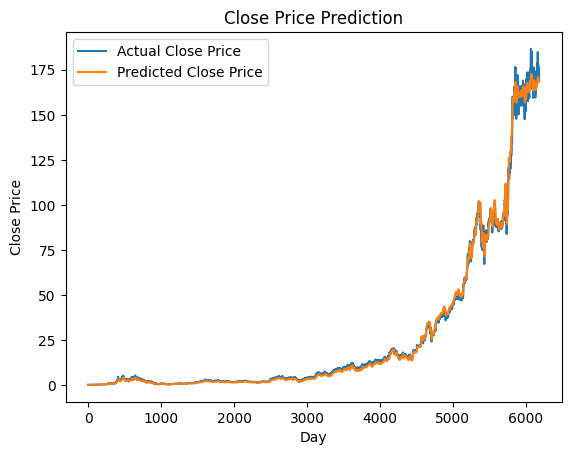

In [164]:
plt.plot(new_Y_train, label='Actual Close Price')
plt.plot(train_predicted, label='Predicted Close Price')
plt.xlabel('Day')
plt.ylabel('Close Price')
plt.title('Close Price Prediction')
plt.legend()
plt.show()

In [165]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([168.00114027, 167.65937128, 167.21033052, 167.111307  ,
       167.24271214, 167.39441556, 167.18190628, 167.27597195,
       167.20322724, 167.25904191, 166.99479762, 166.98293659,
       166.7785644 , 166.39050736, 165.85530458, 165.37627774,
       164.87676366, 164.83973544, 164.56931052, 164.11446152,
       163.91705366, 163.54420365, 163.00488785, 162.15558441,
       160.17291298, 158.31541048, 156.33560704, 154.05649867,
       152.04916028, 150.69549052, 150.4694361 , 151.47073753,
       152.12163821, 151.97834979, 154.00189566, 156.0360242 ,
       157.82607888, 158.91718846, 159.54116559, 159.69542574,
       161.0318542 , 160.94538648, 161.01590239, 160.48301178,
       159.71159988, 158.87532468, 158.02169702, 157.67009015,
       157.51320657, 157.1591319 , 156.81490622, 156.71184194,
       156.45391724, 156.49381901, 155.02854769, 153.0924311 ,
       151.53684584, 151.12327702, 150.43422539, 149.66920533,
       149.77033538, 151.63416858, 154.0889581 , 156.42

In [166]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = Y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([170.01749949, 167.07899763, 170.41700626, 171.03700377,
       171.0684961 , 169.66949429, 170.66099675, 169.20100565,
       168.64449858, 166.71699707, 170.40449492, 167.52200227,
       164.35699578, 163.25399737, 162.55400179, 161.48599177,
       165.36199892, 165.20699954, 161.21400501, 162.13799851,
       158.91749416, 156.29899568, 151.66749509, 142.64300408,
       144.54400445, 139.98599336, 138.87249844, 139.63749627,
       143.97799855, 149.57350001, 151.19349835, 150.61250219,
       138.84550541, 157.63949825, 157.93550165, 161.41349717,
       161.18949925, 159.003495  , 153.29350176, 155.1670061 ,
       156.51049894, 158.10049453, 154.6524962 , 152.60149876,
       150.19749381, 144.82699629, 151.35800212, 153.78849709,
       153.56300403, 151.14199678, 152.05250627, 147.89849848,
       145.64100565, 137.45300383, 136.01449488, 139.27900567,
       146.81750468, 145.52450739, 141.8529947 , 147.36650272,
       153.10400311, 157.23899657, 161.25050521, 161.49

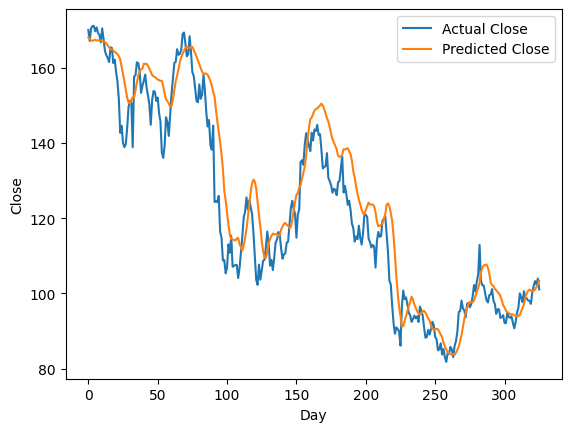

In [167]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [168]:
#export the model
torch.save(model.state_dict(), 'lstm_model.pth')
print('Model saved')

Model saved


2021-12-08 00:00:00 2023-04-05 00:00:00
Initial Cash: $1000
Final Portfolio Value: $1018.19
Total Profit: $18.19


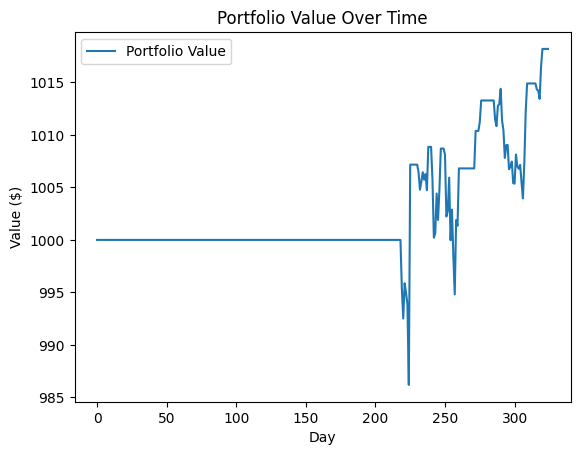

In [169]:
initial_cash = 1000
cash = initial_cash
shares = 0
portfolio_value = []

#print start and end testing dates (the last 5% of the data)
print(data['Date'].iloc[split_index], data['Date'].iloc[-1])



# Parameters
buy_threshold = 1.01  # Buy if predicted price is 1% higher than current price
sell_threshold = 0.99  # Sell if predicted price is 1% lower than current price
position_size = 0.1  # Allocate 10% of cash to each trade

for i in range(1, len(new_y_test)):
    current_price = new_y_test[i]
    predicted_price = test_predictions[i]
    
    # Buy signal: Predicted price is higher than current price by the threshold
    if predicted_price > current_price * buy_threshold and cash >= current_price:
        shares_to_buy = (cash * position_size) // current_price
        shares += shares_to_buy
        cash -= shares_to_buy * current_price
    
    # Sell signal: Predicted price is lower than current price by the threshold
    elif predicted_price < current_price * sell_threshold and shares > 0:
        cash += shares * current_price
        shares = 0
    
    
    portfolio_value.append(cash + shares * current_price)


final_portfolio_value = cash + shares * new_y_test[-1]
total_profit = final_portfolio_value - initial_cash

print(f"Initial Cash: ${initial_cash}")
print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
print(f"Total Profit: ${total_profit:.2f}")


plt.plot(portfolio_value, label='Portfolio Value')
plt.xlabel('Day')
plt.ylabel('Value ($)')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()